In [1]:
import galsim 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
eta1, eta2 = 0.1 ,2
s = galsim.Shear(eta1=100, eta2=0.2)
s.e1

0.9999980000060001

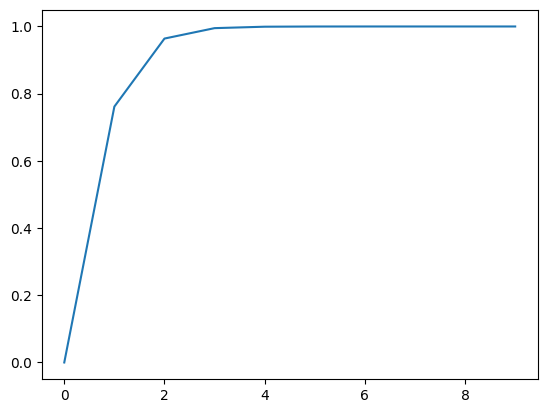

In [3]:
e1 = [galsim.Shear(eta1=x, eta2=0.0).e1 for x in np.arange(10)]
plt.plot(np.arange(10), e1)

In [4]:
etas = (np.random.rand(1000) - 0.5) * 10

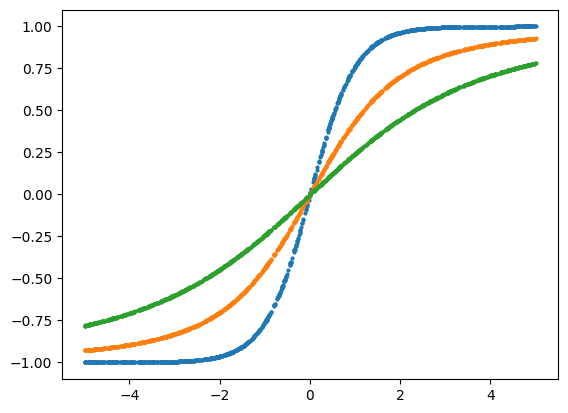

In [5]:
for y in [0, 2, 4]:
    e1s = [galsim.Shear(eta1=x, eta2=y).e1 for x in etas]
    plt.plot(etas, e1s, 'o', markersize=2)


# Transformations

In [6]:
import jax
import jax.numpy as jnp
from jax import grad, vmap

In [7]:
eta = (2, 0.5)
eta_comp = eta[0] + eta[1] * 1j
g_comp = jnp.tanh(eta_comp * 0.5)
g_comp

Array(0.78168831+0.10332941j, dtype=complex128, weak_type=True)

In [8]:
# def eta2g(eta):
#     assert eta.shape == (2,)
#     eta_comp = eta[0] + eta[1] * 1j
#     g_comp = jnp.tanh(eta_comp * 0.5)
#     return jnp.array([g_comp.real, g_comp.imag])

In [9]:
def eta2g(eta):
    assert eta.shape == (2,)
    eta1 = eta[0]
    eta2 = eta[1]
    abseta = jnp.sqrt(eta1**2 + eta2**2)
    g1 = eta1 * jnp.tanh(0.5 * abseta) / abseta
    g2 = eta2 * jnp.tanh(0.5 * abseta) / abseta
    return jnp.array([g1, g2])

In [10]:
def g2eta(g):
    assert g.shape == (2,)
    g1 = g[0]
    g2 = g[1]
    absg = jnp.sqrt(g1**2 + g2**2)
    eta1 = g1 * jnp.arctanh(absg) * 2 / absg
    eta2 = g2 * jnp.arctanh(absg) * 2 / absg
    return jnp.array([eta1, eta2])

In [11]:
eta = jnp.array([1,2])
s = galsim.Shear(eta1=1, eta2=2)
eta2g(eta), s.g1, s.g2

(Array([0.36084949, 0.72169898], dtype=float64),
 0.3608494892040599,
 0.7216989784081198)

In [12]:
g2eta(eta2g(eta))

Array([1., 2.], dtype=float64)

In [13]:
gs = jnp.array([[0.2, 0.4]])

In [14]:
vmap(g2eta)(gs)

Array([[0.43040894, 0.86081788]], dtype=float64)

In [15]:
# gradients 

eta_inv_fnc1 = lambda g: g2eta(g)[0]
eta_inv_fnc2 = lambda g: g2eta(g)[1]

In [16]:
grad(eta_inv_fnc1)(gs[0])

Array([2.22163576, 0.13918212], dtype=float64)

In [17]:
vmap(grad(eta_inv_fnc1))(gs)

Array([[2.22163576, 0.13918212]], dtype=float64)

# Generate (noisy) samples 

In [18]:
from bpd.sample import sample_ellip_prior
from bpd.shear import shear_transformation

In [19]:
k = jax.random.key(52)

In [20]:
es = sample_ellip_prior(k, sigma=1., n=10)
es.shape

(10, 2)

In [21]:
es

Array([[ 0.30901353, -0.13903061],
       [ 0.36031969, -0.0461676 ],
       [ 0.44666394, -0.26755364],
       [ 0.42915883,  0.2710007 ],
       [-0.26980508, -0.68345618],
       [ 0.12889292,  0.23412989],
       [ 0.18267073,  0.34250431],
       [ 0.18203203, -0.2801691 ],
       [ 0.14407943, -0.23815493],
       [-0.44126099,  0.36904614]], dtype=float64)

In [22]:
vmap(g2eta)(es)

Array([[ 0.64345715, -0.28950266],
       [ 0.75511195, -0.09675216],
       [ 0.99041677, -0.59326394],
       [ 0.94604667,  0.5973996 ],
       [-0.68961636, -1.74690026],
       [ 0.264201  ,  0.47991273],
       [ 0.38555244,  0.72290384],
       [ 0.37859755, -0.58270696],
       [ 0.29596703, -0.48921632],
       [-1.00538059,  0.84084439]], dtype=float64)

In [23]:
def sample_noisy_eta(rng_key, *, g, sigma_e:float, sigma_m:float, n:int=1):
    k1, k2 = jax.random.split(rng_key)
    es = sample_ellip_prior(k1, sigma_e, n)
    essh = shear_transformation(es, g)
    etas = vmap(g2eta)(essh)
    noisy_etas = etas.reshape(n, 2) + jax.random.normal(k2, shape=(n, 2)) * sigma_m
    return noisy_etas, etas
    
    

In [24]:
netas, etas = sample_noisy_eta(k, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=100_000)

In [25]:
etas.shape

(100000, 2)

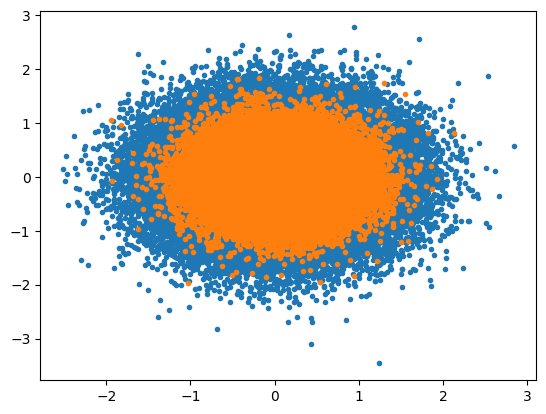

In [26]:
plt.plot(netas[:, 0], netas[:, 1], 'o', markersize=3)
plt.plot(etas[:, 0], etas[:, 1], 'o', markersize=3)

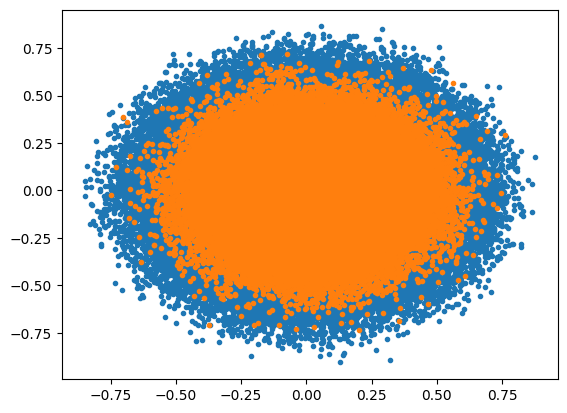

In [27]:
nes = vmap(eta2g)(netas)
es = vmap(eta2g)(etas)
plt.plot(nes[:, 0], nes[:, 1], 'o', markersize=3)
plt.plot(es[:, 0], es[:, 1], 'o', markersize=3)

In [28]:
nes[:, 0].mean(), es[:, 0].mean()

(Array(0.0167261, dtype=float64), Array(0.01940866, dtype=float64))

## Validation

In [29]:
from bpd.sample import sample_ellip_prior

In [30]:
n = 10000000

In [31]:
netas, etas = sample_noisy_eta(k, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=n)
es_eta = vmap(eta2g)(etas)
nes_eta = vmap(eta2g)(netas)
es_eta[:, 0].mean(), nes_eta[:, 0].mean()

(Array(0.01997347, dtype=float64), Array(0.01862445, dtype=float64))

In [32]:
k1, k2 = jax.random.split(k)
es = sample_ellip_prior(k1, sigma=0.2, n=10000000)
essh = shear_transformation(es, jnp.array([0.02, 0.0]))
essh[:, 0].mean()

Array(0.01997347, dtype=float64)

# Likelihood

In [33]:
from bpd.prior import ellip_prior_e1e2
from jax.scipy.stats import norm
from jax import grad 

eta_inv_fnc1 = lambda eta: eta2g(eta)[0]
eta_inv_fnc2 = lambda eta: eta2g(eta)[1]

grad_fnc1 = grad(eta_inv_fnc1)
grad_fnc2 = grad(eta_inv_fnc2)


def eta_target(eta, *, data, sigma_e:float, sigma_m:float):
    neta = data
    llike = norm.logpdf(neta, loc=eta, scale=sigma_m).sum()

    e1e2 = eta2g(eta)
    lprior1 = jnp.log(ellip_prior_e1e2(e1e2, sigma_e))

    grad1 = grad_fnc1(eta)
    grad2 = grad_fnc2(eta)
    prior2 = jnp.abs(grad1[...,0] * grad2[...,1] - grad1[...,1] * grad2[...,0])
    lprior2 = jnp.log(prior2)

    return llike + lprior1 + lprior2

In [34]:
eta_target(etas[0], data=netas[0], sigma_e=0.2, sigma_m=0.5)

Array(-3.53450562, dtype=float64)

# Run infrence (phase I)

In [81]:
from bpd.chains import run_inference_nuts
from jax import random 

from functools import partial

In [82]:
k1, k2 = random.split(random.key(42))

In [83]:
n = 10_000
netas, etas = sample_noisy_eta(k1, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=n)
netas.shape, etas.shape

((10000, 2), (10000, 2))

In [84]:
k2s = random.split(k2, (n,))
k2s.shape

(10000,)

In [85]:
target = partial(eta_target, sigma_e=0.3, sigma_m=0.5)

pipe = partial(run_inference_nuts, logtarget=target, n_samples=1000, initial_step_size=0.01, max_num_doublings=2)

In [86]:
samples = vmap(pipe)(k2s, netas, etas)

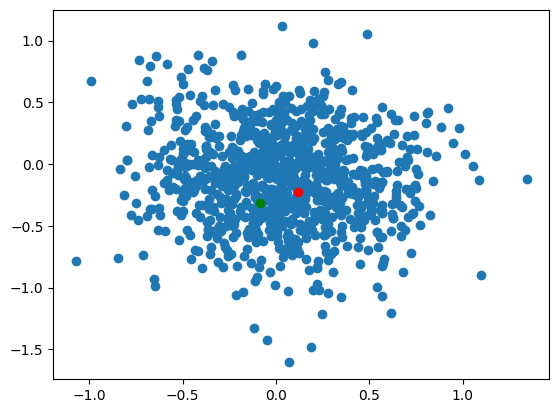

In [87]:
plt.plot(samples[0, :, 0], samples[0, :, 1], 'o')
plt.plot(netas[0, 0], netas[0, 1], 'ro')
plt.plot(etas[0,0], etas[0, 1], 'go')

In [88]:
samples_es = vmap(vmap(eta2g))(samples) 
nes = vmap(eta2g)(netas)
es = vmap(eta2g)(etas)

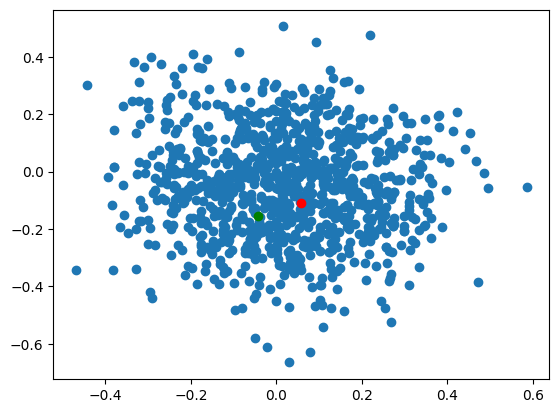

In [89]:
plt.plot(samples_es[0, :, 0], samples_es[0, :, 1], 'o')
plt.plot(nes[0, 0], nes[0, 1], 'ro')
plt.plot(es[0,0], es[0, 1], 'go')

# Phase II target and inference run 

In [90]:
from bpd.prior import ellip_prior_e1e2
from jax.scipy.stats import norm
from jax import grad 
import jax.scipy as jsp
from bpd.utils import uniform_logpdf

from bpd.shear import (
    inv_shear_func1,
    inv_shear_func2,
    inv_shear_transformation,
)

eta_inv_fnc1 = lambda eta: eta2g(eta)[0]
eta_inv_fnc2 = lambda eta: eta2g(eta)[1]
grad_eta_fnc1 = vmap(vmap(grad(eta_inv_fnc1)))
grad_eta_fnc2 = vmap(vmap(grad(eta_inv_fnc2)))


_grad_shear_fnc1 = vmap(vmap(grad(inv_shear_func1), in_axes=(0, None)), in_axes=(0, None))
_grad_shear_fnc2 = vmap(vmap(grad(inv_shear_func2), in_axes=(0, None)), in_axes=(0, None))
_inv_shear_trans = vmap(inv_shear_transformation, in_axes=(0, None)) # already vmapped once


def shear_eta_target(g, *, data, sigma_e:float, sigma_e_int:float):
    assert g.shape == (2,)
    assert data.ndim == 3 and data.shape[2] == 2
    etas = data

    # P(eta' | alpha, g) = P(eps | alpha) * (del eps' / del eta') * (del eps / del eps')
    eps_sheared = vmap(vmap(eta2g))(etas)
    eps = _inv_shear_trans(eps_sheared, g)
    num1 = jnp.log(ellip_prior_e1e2(eps, sigma_e))

    # need to calculate both grads ===> cancels with the denom
    # grad_eta1 = grad_eta_fnc1(etas)
    # grad_eta2 = grad_eta_fnc2(etas)
    # jac1 = jnp.abs(grad_eta1[...,0] * grad_eta2[...,1] - grad_eta1[...,1] * grad_eta2[...,0])
    # ljac1 = jnp.log(jac1)

    grad_eps1 = _grad_shear_fnc1(eps_sheared, g)
    grad_eps2 = _grad_shear_fnc2(eps_sheared, g)
    jac2 = jnp.abs(grad_eps1[..., 0] * grad_eps2[..., 1] - grad_eps1[..., 1] * grad_eps2[..., 0])
    num2 = jnp.log(jac2)

    num = num1 + num2

    # now denom P0(eta') = P0(eps') * (del eps' / del eta')
    denom = jnp.log(ellip_prior_e1e2(eps_sheared, sigma_e_int))

    ratio = jsp.special.logsumexp(num - denom, axis=-1)
    loglike = ratio.sum()

    # prior on shear
    g_mag = jnp.sqrt(g[0] ** 2 + g[1] ** 2)
    logprior = uniform_logpdf(g_mag, 0.0, 1.0) + jnp.log(1 / (2 * jnp.pi))

    return logprior + loglike

In [91]:
target = partial(shear_eta_target, sigma_e=0.2, sigma_e_int=0.3)

In [92]:
true_g = jnp.array([0.02, 0.0])

In [93]:
target(true_g, data=samples)

Array(69513.2866133, dtype=float64)

In [94]:
gs = jnp.linspace(-0.1, 0.1, 100)
ls = [target(jnp.array([g, 0.0]), data=samples) for g in gs]

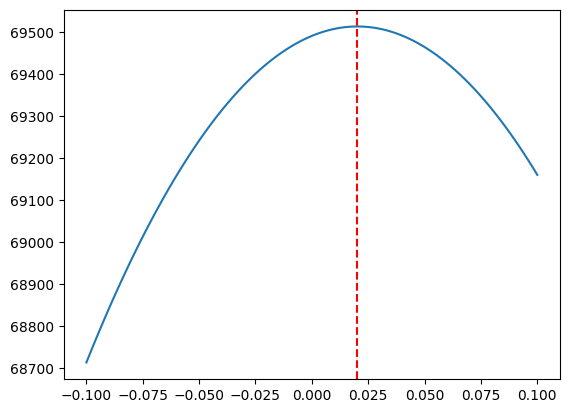

In [95]:
plt.plot(gs, ls)
plt.axvline(0.02, ls='--', c='r')

# looks peaked at correct value

# Run shear chain

In [99]:
from jax import jit 

In [100]:
key = random.key(61)

In [101]:
target = partial(shear_eta_target, sigma_e=0.2, sigma_e_int=0.3)
pipe = jit(partial(run_inference_nuts, logtarget=target, n_samples=2000, initial_step_size=0.01, max_num_doublings=2))

In [102]:
g_samples = pipe(key, samples, jnp.array([0.02, 0.0]))

In [103]:
g_samples.shape

(2000, 2)

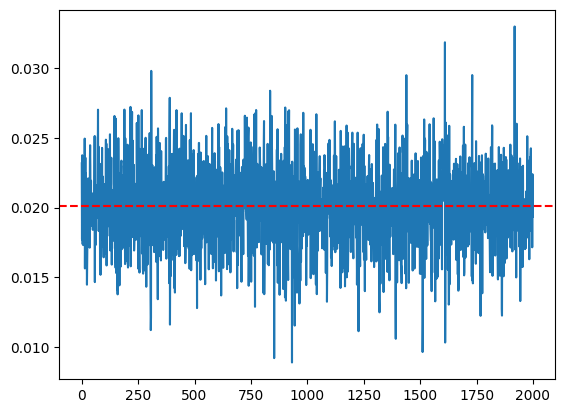

In [109]:
plt.plot(g_samples[:, 0])
plt.axhline(g_samples[:, 0].mean(), ls='--', c='r')

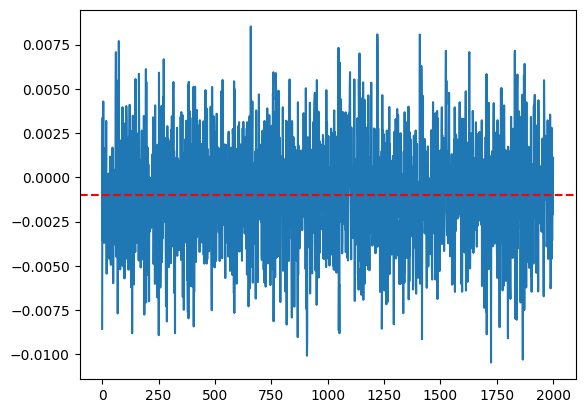

In [108]:
plt.plot(g_samples[:, 1])
plt.axhline(g_samples[:, 1].mean(), ls='--', c='r')